In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('./小型CSV数据/Tweets.csv')

In [3]:
data = data[['airline_sentiment', 'text']]

In [4]:
data.head()

airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...

In [5]:
data.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [6]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
data_p = data[data.airline_sentiment == 'positive']

In [8]:
data_n = data[data.airline_sentiment == 'negative']

In [9]:
data_n = data_n.iloc[:len(data_p)]

In [10]:
len(data_n), len(data_p)

(2363, 2363)

In [11]:
data = pd.concat([data_n, data_p]) # pandas Top and bottom stitching

In [12]:
data = data.sample(len(data))  #使数据乱序

In [13]:
data['review'] = (data.airline_sentiment == 'positive').astype('int')

In [14]:
del data['airline_sentiment']

tf.keras.layers.Embedding  Vectorize text

In [15]:
import re

In [16]:
token = re.compile('[A-Za-z]+|[!?,.()]')

In [17]:
def reg_text(text):
    new_text = token.findall(text)
    new_text = [word.lower() for word in new_text]
    return new_text

In [18]:
data['text'] = data.text.apply(reg_text)

In [19]:
data

text  review
10487  [usairways, thank, you, !, it, s, from, bwi, ,...       1
321    [virginamerica, wtf, is, happening, in, pdx, l...       0
1634   [united, you, have, a, guy, named, otis, at, o...       1
527    [united, just, wanted, to, let, you, know, how...       1
5481   [southwestair, first, time, flying, with, you,...       1
...                                                  ...     ...
3317   [united, has, the, best, pilots, ever, thank, ...       1
3466   [united, reflight, booking, problems, would, n...       0
1910   [united, please, follow, faa, guidelines, rega...       0
3041   [united, education, of, that, staff, is, neede...       0
1730   [united, of, first, seats, open, on, ua, ., no...       0

[4726 rows x 2 columns]

In [20]:
# using 'set' get rid of common word
word_set = set()
for text in data.text:
    for word in text:
        word_set.add(word) 

In [21]:
max_word = len(word_set) + 1
max_word

7101

In [22]:
word_list = list(word_set)

In [23]:
word_index =  dict((word, word_list.index(word) + 1) for word in word_list)

In [24]:
data_ok = data.text.apply(lambda x: [word_index.get(word, 0) for word in x])

In [25]:
len(data_ok.iloc[2])

31

In [26]:
maxlen = max(len(x) for x in data_ok)

In [27]:
data_ok = keras.preprocessing.sequence.pad_sequences(data_ok.values, maxlen=maxlen)

In [28]:
data_ok.shape

(4726, 40)

In [29]:
data.review.values

array([1, 0, 1, ..., 0, 0, 0])

In [30]:
model = keras.Sequential()

Embeding : Map the text to a dense vector

In [31]:
model.add(layers.Embedding(max_word, 50, input_length=maxlen))

In [32]:
model.add(layers.LSTM(64))

In [33]:
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            355050    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 384,555
Trainable params: 384,555
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

In [36]:
history = model.fit(data_ok, data.review.values, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
30/30 [==============================] - 3s 97ms/step - loss: 0.6396 - acc: 0.6352 - val_loss: 0.5503 - val_acc: 0.7262
Epoch 2/10
30/30 [==============================] - 2s 69ms/step - loss: 0.3801 - acc: 0.8347 - val_loss: 0.2641 - val_acc: 0.8700
Epoch 3/10
30/30 [==============================] - 2s 71ms/step - loss: 0.1553 - acc: 0.9484 - val_loss: 0.1918 - val_acc: 0.9302
Epoch 4/10
30/30 [==============================] - 2s 67ms/step - loss: 0.0935 - acc: 0.9696 - val_loss: 0.1965 - val_acc: 0.9334
Epoch 5/10
30/30 [==============================] - 2s 54ms/step - loss: 0.0566 - acc: 0.9844 - val_loss: 0.2295 - val_acc: 0.9207
Epoch 6/10
30/30 [==============================] - 2s 53ms/step - loss: 0.0383 - acc: 0.9899 - val_loss: 0.2451 - val_acc: 0.9334
Epoch 7/10
30/30 [==============================] - 2s 54ms/step - loss: 0.0225 - acc: 0.9942 - val_loss: 0.2764 - val_acc: 0.9218
Epoch 8/10
30/30 [==============================] - 2s 56ms/step - loss: 0.0245 - a

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

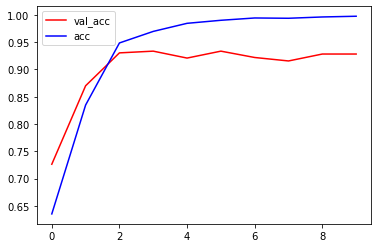

In [38]:
plt.plot(history.epoch, history.history.get('val_acc'), c='r', label='val_acc')
plt.plot(history.epoch, history.history.get('acc'), c='b', label='acc')
plt.legend()

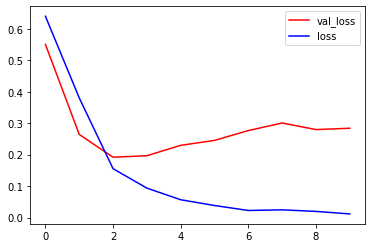

In [39]:
plt.plot(history.epoch, history.history.get('val_loss'), c='r', label='val_loss')
plt.plot(history.epoch, history.history.get('loss'), c='b', label='loss')
plt.legend()

dropout to reduce overfitting

In [40]:
def train_model():
    model = keras.Sequential()
    model.add(layers.Embedding(max_word, 16, input_length=maxlen))
    model.add(layers.LSTM(64,
                         dropout=0.2,
                         recurrent_dropout=0.5))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [41]:
model2 = train_model()

In [42]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 16)            113616    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 134,417
Trainable params: 134,417
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model2.fit(data_ok, data.review.values, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
30/30 [==============================] - 2s 78ms/step - loss: 0.6439 - acc: 0.6325 - val_loss: 0.5550 - val_acc: 0.7400
Epoch 2/10
30/30 [==============================] - 2s 62ms/step - loss: 0.4881 - acc: 0.7770 - val_loss: 0.3757 - val_acc: 0.8414
Epoch 3/10
30/30 [==============================] - 2s 64ms/step - loss: 0.3119 - acc: 0.8802 - val_loss: 0.2493 - val_acc: 0.9218
Epoch 4/10
30/30 [==============================] - 2s 62ms/step - loss: 0.2242 - acc: 0.9265 - val_loss: 0.2179 - val_acc: 0.9207
Epoch 5/10
30/30 [==============================] - 2s 63ms/step - loss: 0.1777 - acc: 0.9437 - val_loss: 0.2043 - val_acc: 0.9323
Epoch 6/10
30/30 [==============================] - 2s 70ms/step - loss: 0.1457 - acc: 0.9540 - val_loss: 0.2396 - val_acc: 0.8975
Epoch 7/10
30/30 [==============================] - 2s 63ms/step - loss: 0.1274 - acc: 0.9614 - val_loss: 0.2224 - val_acc: 0.9355
Epoch 8/10
30/30 [==============================] - 2s 63ms/step - loss: 0.1106 - a

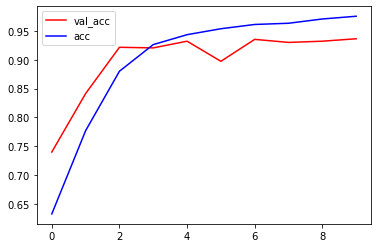

In [44]:
plt.plot(history.epoch, history.history.get('val_acc'), c='r', label='val_acc')
plt.plot(history.epoch, history.history.get('acc'), c='b', label='acc')
plt.legend()

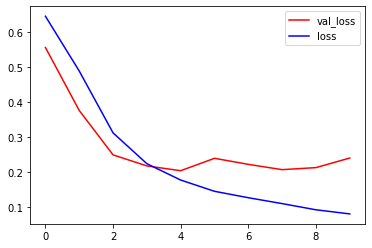

In [45]:
plt.plot(history.epoch, history.history.get('val_loss'), c='r', label='val_loss')
plt.plot(history.epoch, history.history.get('loss'), c='b', label='loss')
plt.legend()

# Bidirection RNN

In [46]:
def train_model():
    model = keras.Sequential()
    model.add(layers.Embedding(max_word, 16, input_length=maxlen))
    model.add(layers.Bidirectional(layers.LSTM(64,
                         dropout=0.2,
                         recurrent_dropout=0.5)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [47]:
model3 = train_model()

In [48]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 16)            113616    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 155,217
Trainable params: 155,217
Non-trainable params: 0
_________________________________________________________________


In [49]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=0.00001)

In [50]:
history = model3.fit(data_ok, 
                     data.review.values, 
                     epochs=30, 
                     batch_size=128, 
                     validation_split=0.2,
                     callbacks=[learning_rate_reduction])

Epoch 1/30
30/30 [==============================] - 6s 192ms/step - loss: 0.5977 - acc: 0.6738 - val_loss: 0.4565 - val_acc: 0.8002
Epoch 2/30
30/30 [==============================] - 4s 121ms/step - loss: 0.3519 - acc: 0.8582 - val_loss: 0.4040 - val_acc: 0.8277
Epoch 3/30
30/30 [==============================] - 4s 132ms/step - loss: 0.2227 - acc: 0.9146 - val_loss: 0.2569 - val_acc: 0.9027
Epoch 4/30
30/30 [==============================] - 3s 94ms/step - loss: 0.1577 - acc: 0.9471 - val_loss: 0.2337 - val_acc: 0.9059
Epoch 5/30
30/30 [==============================] - 3s 93ms/step - loss: 0.1229 - acc: 0.9577 - val_loss: 0.2411 - val_acc: 0.9144
Epoch 6/30
30/30 [==============================] - 3s 89ms/step - loss: 0.1085 - acc: 0.9635 - val_loss: 0.2487 - val_acc: 0.9144
Epoch 7/30
30/30 [==============================] - 3s 93ms/step - loss: 0.0928 - acc: 0.9693 - val_loss: 0.2043 - val_acc: 0.9123
Epoch 8/30
30/30 [==============================] - 3s 97ms/step - loss: 0.0663 

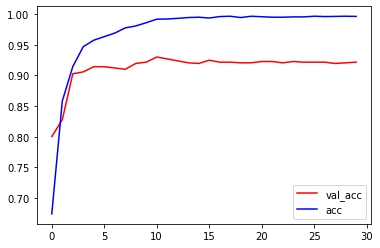

In [51]:
plt.plot(history.epoch, history.history.get('val_acc'), c='r', label='val_acc')
plt.plot(history.epoch, history.history.get('acc'), c='b', label='acc')
plt.legend()

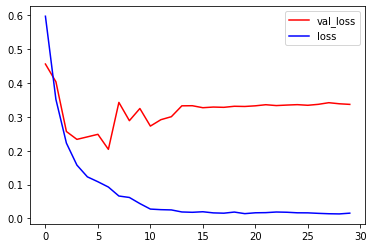

In [52]:
plt.plot(history.epoch, history.history.get('val_loss'), c='r', label='val_loss')
plt.plot(history.epoch, history.history.get('loss'), c='b', label='loss')
plt.legend()